In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
df = pd.read_csv('data.csv',low_memory=False)
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,DAYS_SINCE_LASTORDER,STATUS,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,24/02/2018,828,Shipped,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,10022,USA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,07/05/2018,757,Shipped,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,51100,France,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,01/07/2018,703,Shipped,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,25/08/2018,649,Shipped,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,90003,USA,Young,Julie,Medium
4,10168,36,96.66,1,3479.76,28/10/2018,586,Shipped,Motorcycles,95,S10_1678,Technics Stores Inc.,6505556809,9408 Furth Circle,Burlingame,94217,USA,Hirano,Juri,Medium


In [3]:
df = df.drop(columns=["PHONE","ADDRESSLINE1","POSTALCODE","CONTACTLASTNAME","CONTACTFIRSTNAME"])

In [4]:
df['DAYS_SINCE_LASTORDER'].nunique()

1832

In [5]:
import pandas as pd

# Veri yüklenirken sütun adlarını senkronize edelim
df = pd.read_csv("data.csv", parse_dates=["ORDERDATE"])

# Kolaylık için isimleri değiştiriyoruz
df = df.rename(columns={
    "CUSTOMERNAME": "musteri_id",
    "ORDERDATE": "tarih",
    "SALES": "satis_tutari"
})


C:\Users\Serhat Turan\AppData\Local\Temp\ipykernel_10772\1385482664.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv("data.csv", parse_dates=["ORDERDATE"])


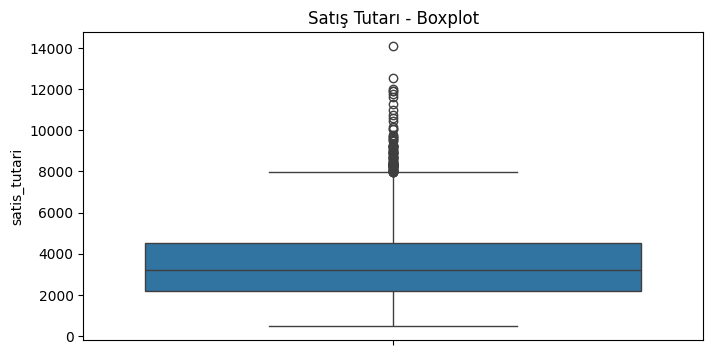

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.boxplot(df["satis_tutari"])
plt.title("Satış Tutarı - Boxplot")
plt.show()


In [7]:
Q1 = df["satis_tutari"].quantile(0.25)
Q3 = df["satis_tutari"].quantile(0.75)
IQR = Q3 - Q1
alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

df_clean = df[(df["satis_tutari"] >= alt_sinir) & (df["satis_tutari"] <= ust_sinir)]


In [8]:
ref_date = df_clean["tarih"].max() + pd.Timedelta(days=1)


In [9]:
rfm = df_clean.groupby("musteri_id").agg({
    "tarih": lambda x: (ref_date - x.max()).days,  # Recency
    "tarih": "count",                              # Frequency
    "satis_tutari": "sum"                          # Monetary
}).rename(columns={
    "tarih": "Frequency",   # overwrite oldu, düzeltelim
    "<lambda_0>": "Recency",
    "satis_tutari": "Monetary"
}).reset_index()

# Lambda fonksiyonunun adı düzgün gelmediği için manuel olarak Recency hesaplayalım:
recency_df = df_clean.groupby("musteri_id").agg({
    "tarih": lambda x: (ref_date - x.max()).days
}).rename(columns={"tarih": "Recency"})

rfm = rfm.merge(recency_df, on="musteri_id")


In [10]:
rfm = rfm[["musteri_id", "Recency", "Frequency", "Monetary"]]


In [11]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5, 4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)


In [12]:
def segment(rfm_score):
    if rfm_score.startswith("5"):
        return "Yeni ve Değerli"
    elif rfm_score.startswith("1"):
        return "Kaybedilen Müşteri"
    else:
        return "Orta Seviye"

rfm["Segment"] = rfm["RFM_Score"].apply(segment)


In [13]:
# Orijinal veriyle başlayalım (df_clean üzerinden)
lokasyon = df_clean[["musteri_id", "CITY", "COUNTRY"]].drop_duplicates()

# CITY ve COUNTRY'yi one-hot encode et
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False
)
lokasyon_encoded = encoder.fit_transform(lokasyon[["CITY", "COUNTRY"]])

# Encode edilmiş veriyi DataFrame'e çevir
encoded_df = pd.DataFrame(lokasyon_encoded, columns=encoder.get_feature_names_out(["CITY", "COUNTRY"]))
lokasyon_df = pd.concat([lokasyon.reset_index(drop=True), encoded_df], axis=1)


In [14]:
from sklearn.decomposition import PCA

# Boyutu 2'ye indirelim, bu benzerlik için yeterli
pca = PCA(n_components=2)
lokasyon_pca = pca.fit_transform(encoded_df)

# Yeni sütunları ekle
lokasyon_df["loc_pca_1"] = lokasyon_pca[:, 0]
lokasyon_df["loc_pca_2"] = lokasyon_pca[:, 1]


In [15]:
# RFM analizi sonucu oluşan DataFrame (önceden hazırlanmış olmalı)
# rfm: musteri_id, Recency, Frequency, Monetary, RFM_Score, Segment gibi sütunlar içerir

# Şehir/ülke PCA dönüşümü sonucu elde ettiğimiz lokasyon_df
# lokasyon_df: musteri_id, loc_pca_1, loc_pca_2

# Bu iki tabloyu birleştiriyoruz:
rfm_merged = pd.merge(
    rfm,
    lokasyon_df[["musteri_id", "loc_pca_1", "loc_pca_2"]],
    on="musteri_id",
    how="left"
)


In [16]:
ozellikler = ["Recency", "Frequency", "Monetary", "loc_pca_1", "loc_pca_2"]
X = rfm_merged[ozellikler]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(X_scaled)

musteri_ids = rfm_merged["musteri_id"].values
similarity_df = pd.DataFrame(similarity_matrix, index=musteri_ids, columns=musteri_ids)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

similarity_matrix = cosine_similarity(X_scaled)

# Müşteri adlarını ekleyelim
musteri_ids = rfm_merged["musteri_id"].values
similarity_df = pd.DataFrame(similarity_matrix, index=musteri_ids, columns=musteri_ids)


In [19]:
print(similarity_df.head())  # veya
display(similarity_df.head())  # Jupyter içindeysen daha güzel görünür


                         AV Stores, Co.  Alpha Cognac  Amica Models & Co.  \
AV Stores, Co.                 1.000000     -0.467319            0.452641   
Alpha Cognac                  -0.467319      1.000000           -0.356389   
Amica Models & Co.             0.452641     -0.356389            1.000000   
Anna's Decorations, Ltd        0.796129     -0.192200            0.162347   
Atelier graphique             -0.561090      0.913835           -0.105521   

                         Anna's Decorations, Ltd  Atelier graphique  \
AV Stores, Co.                          0.796129          -0.561090   
Alpha Cognac                           -0.192200           0.913835   
Amica Models & Co.                      0.162347          -0.105521   
Anna's Decorations, Ltd                 1.000000          -0.471809   
Atelier graphique                      -0.471809           1.000000   

                         Australian Collectables, Ltd  \
AV Stores, Co.                               0.279471

,"AV Stores, Co.",Alpha Cognac,Amica Models & Co.,"Anna's Decorations, Ltd",Atelier graphique,"Australian Collectables, Ltd","Australian Collectors, Co.","Australian Gift Network, Co",Auto Assoc. & Cie.,Auto Canal Petit,...,"Tokyo Collectables, Ltd","Toms Spezialitten, Ltd","Toys of Finland, Co.",Toys4GrownUps.com,"UK Collectables, Ltd.","Vida Sport, Ltd",Vitachrome Inc.,"Volvo Model Replicas, Co",West Coast Collectables Co.,giftsbymail.co.uk
"AV Stores, Co.",1.000000,-0.467319,0.452641,0.796129,-0.561090,0.279471,0.987259,0.290674,-0.463956,-0.411315,...,0.430145,0.626779,0.663452,-0.619796,0.500675,0.678892,-0.664434,0.409617,-0.338578,0.649812
Alpha Cognac,-0.467319,1.000000,-0.356389,-0.192200,0.913835,0.059358,-0.425227,-0.083500,0.863485,0.985019,...,0.110008,-0.364363,-0.091851,-0.190460,-0.060049,-0.434451,-0.268377,-0.178890,-0.379003,-0.408809
Amica Models & Co.,0.452641,-0.356389,1.000000,0.162347,-0.105521,0.183314,0.326340,0.573208,-0.057597,-0.436507,...,-0.018036,0.958729,0.341492,-0.666990,0.222816,0.879447,-0.458943,0.875791,0.305314,0.906461
"Anna's Decorations, Ltd",0.796129,-0.192200,0.162347,1.000000,-0.471809,0.746139,0.806262,0.578581,-0.489549,-0.183286,...,0.883203,0.414871,0.932185,-0.444441,0.884384,0.220021,-0.698530,0.415013,-0.787287,0.541343
Atelier graphique,-0.561090,0.913835,-0.105521,-0.471809,1.000000,-0.168922,-0.558320,-0.136124,0.980233,0.880047,...,-0.212840,-0.208945,-0.311719,-0.242964,-0.308822,-0.213975,-0.165420,-0.071119,-0.003683,-0.315550


In [20]:
print(rfm_merged.head())


                musteri_id  Recency  Frequency   Monetary R_Score F_Score  \
0           AV Stores, Co.      197         51  157807.81       3       5   
1             Alpha Cognac       65         19   62156.83       4       2   
2       Amica Models & Co.      266         23   69437.88       1       3   
3  Anna's Decorations, Ltd       84         44  137181.28       4       5   
4        Atelier graphique      189          7   24179.96       3       1   

  M_Score RFM_Score             Segment  loc_pca_1  loc_pca_2  
0       5       355         Orta Seviye  -0.356142  -0.334931  
1       2       422         Orta Seviye  -0.585880   0.746445  
2       2       132  Kaybedilen Müşteri  -0.320120  -0.236602  
3       5       455         Orta Seviye  -0.354455  -0.322212  
4       1       311         Orta Seviye  -0.611751   0.824791  


In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
X = rfm_merged[["Recency", "Frequency", "Monetary", "loc_pca_1", "loc_pca_2"]]
X_scaled = StandardScaler().fit_transform(X)

rfm_merged["cluster"] = kmeans.fit_predict(X_scaled)


In [22]:
from sklearn.preprocessing import StandardScaler

ozellikler = ["Recency", "Frequency", "Monetary", "loc_pca_1", "loc_pca_2"]
X = rfm_merged[ozellikler]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


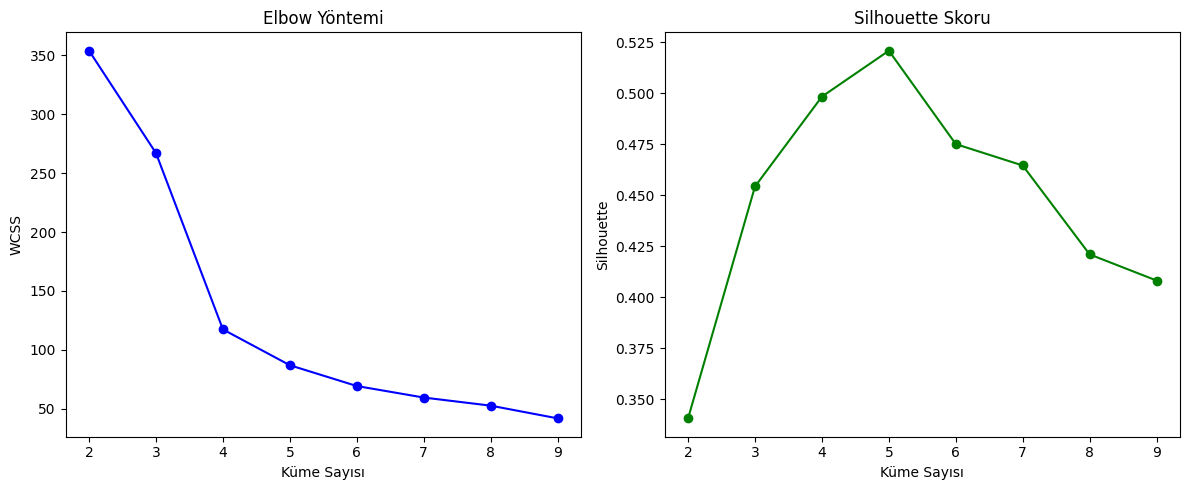

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    preds = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, preds))

# Elbow grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, 'bo-')
plt.title('Elbow Yöntemi')
plt.xlabel('Küme Sayısı')
plt.ylabel('WCSS')

# Silhouette skoru grafiği
plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, 'go-')
plt.title('Silhouette Skoru')
plt.xlabel('Küme Sayısı')
plt.ylabel('Silhouette')

plt.tight_layout()
plt.show()


In [24]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_merged["cluster"] = kmeans.fit_predict(X_scaled)


In [25]:
# Her kümenin ortalama RFM skorlarına bakalım
rfm_merged.groupby("cluster")[["Recency", "Frequency", "Monetary"]].mean()


,Recency,Frequency,Monetary
cluster,,,
0,207.903226,23.483871,81110.765161
1,173.409091,27.568182,92860.153182
2,166.250000,25.083333,82587.549167
3,2.000000,213.000000,722988.710000


In [26]:
rfm_merged.groupby("cluster")[["loc_pca_1", "loc_pca_2"]].mean()


,loc_pca_1,loc_pca_2
cluster,,
0,0.691733,0.078274
1,-0.328660,-0.265401
2,-0.603725,0.803269
3,0.130995,-0.194027


In [27]:
rfm_merged["cluster"].value_counts().sort_index()


cluster
0    31
1    44
2    12
3     2
Name: count, dtype: int64

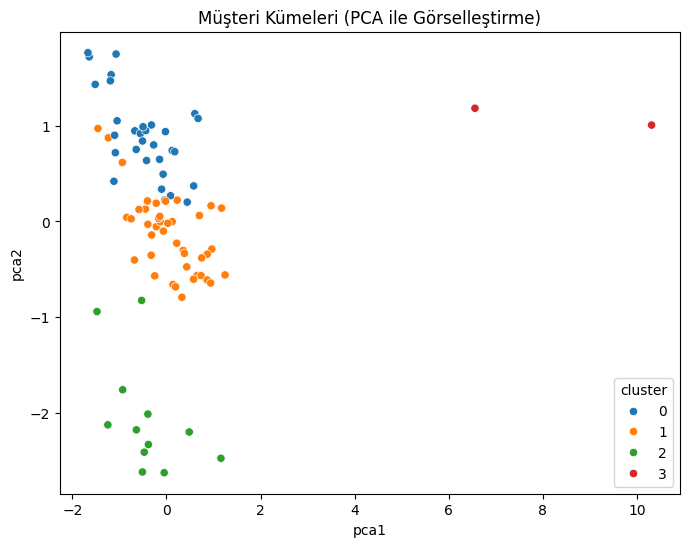

In [28]:
from sklearn.decomposition import PCA
import seaborn as sns

pca_2d = PCA(n_components=2)
pca_components = pca_2d.fit_transform(X_scaled)

rfm_merged["pca1"] = pca_components[:, 0]
rfm_merged["pca2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_merged, x="pca1", y="pca2", hue="cluster", palette="tab10")
plt.title("Müşteri Kümeleri (PCA ile Görselleştirme)")
plt.show()


In [29]:
rfm_summary = rfm_merged.groupby("cluster")[["Recency", "Frequency", "Monetary"]].mean().round(1)
print(rfm_summary)


         Recency  Frequency  Monetary
cluster                              
0          207.9       23.5   81110.8
1          173.4       27.6   92860.2
2          166.2       25.1   82587.5
3            2.0      213.0  722988.7


In [30]:
cluster_counts = rfm_merged["cluster"].value_counts().sort_index()
print(cluster_counts)


cluster
0    31
1    44
2    12
3     2
Name: count, dtype: int64


In [31]:
sales_summary = rfm_merged.groupby("cluster")["Monetary"].agg(["sum", "mean", "count"]).round(1)
print(sales_summary)


               sum      mean  count
cluster                            
0        2514433.7   81110.8     31
1        4085846.7   92860.2     44
2         991050.6   82587.5     12
3        1445977.4  722988.7      2


In [32]:
segment_mapping = {
    0: "Kaybedilen",
    1: "Sadık müşteriler",
    2: "Potansiyel sadık müşteriler",
    3: "Şampiyon müşteriler"
}
rfm_merged["segment"] = rfm_merged["cluster"].map(segment_mapping)


C:\Users\Serhat Turan\AppData\Local\Temp\ipykernel_10772\4273186679.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rfm_merged, x="segment", y="Monetary", estimator="sum", ci=None)


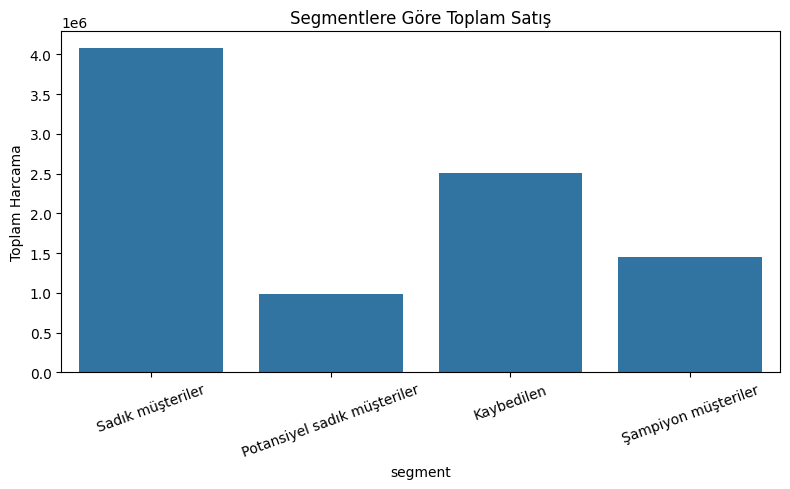

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=rfm_merged, x="segment", y="Monetary", estimator="sum", ci=None)
plt.title("Segmentlere Göre Toplam Satış")
plt.ylabel("Toplam Harcama")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [34]:
pivot_df = df.pivot_table(index="musteri_id", columns="PRODUCTCODE", values="QUANTITYORDERED", aggfunc="sum")
pivot_df = pivot_df.fillna(0)


In [35]:
print(df.columns.tolist())



['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'satis_tutari', 'tarih', 'DAYS_SINCE_LASTORDER', 'STATUS', 'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'musteri_id', 'PHONE', 'ADDRESSLINE1', 'CITY', 'POSTALCODE', 'COUNTRY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME', 'DEALSIZE']


In [36]:
def en_benzer_musteriler(musteri_id, similarity_df, N=5):
    benzerlikler = similarity_df.loc[musteri_id].sort_values(ascending=False)
    benzerlikler = benzerlikler.drop(musteri_id)  # Kendini çıkar
    return benzerlikler.head(N).index.tolist()


In [37]:
def oneriler_getir(musteri_id, pivot_df, similarity_df, top_n=5):
    benzerler = en_benzer_musteriler(musteri_id, similarity_df, N=5)
    
    musteri_urunler = pivot_df.loc[musteri_id]
    musteri_aldi = musteri_urunler[musteri_urunler > 0].index.tolist()
    
    # Benzerlerin aldığı ürünleri topla
    urun_skorlari = pivot_df.loc[benzerler].sum()
    
    # Müşterinin zaten aldığı ürünleri çıkar
    urun_skorlari = urun_skorlari.drop(labels=musteri_aldi, errors="ignore")
    
    # En çok alınan ürünleri öner
    oneriler = urun_skorlari.sort_values(ascending=False).head(top_n)
    return oneriler


In [38]:
musteri = rfm_merged["musteri_id"].iloc[0]  # İlk müşteri
print(f"{musteri} için öneriler:")
print(oneriler_getir(musteri, pivot_df, similarity_df))


AV Stores, Co. için öneriler:
PRODUCTCODE
S18_2432    181.0
S18_1097    171.0
S12_1666    165.0
S10_4962    163.0
S50_1341    163.0
dtype: float64


In [39]:
# Ürün başına ortalama fiyat çıkar (ürün özelliklerinden biri)
products_df = df.groupby("PRODUCTCODE")[["PRICEEACH"]].mean().reset_index()

# Örneğin dummy kategori ekleyelim (ürün kodundan biraz çekip)
products_df["CATEGORY"] = products_df["PRODUCTCODE"].str[0]  # ürün kodunun ilk harfi kategori gibi olsun

print(products_df.head())


  PRODUCTCODE   PRICEEACH CATEGORY
0    S10_1678  100.510833        S
1    S10_1949  199.523846        S
2    S10_2016  114.571667        S
3    S10_4698  187.118750        S
4    S10_4757  118.293200        S


In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Örnek: kategori sütununa one-hot encoding uygulayalım
encoder = OneHotEncoder(sparse_output=False)
category_encoded = encoder.fit_transform(products_df[["CATEGORY"]])

# Fiyatı normalize edelim
scaler = StandardScaler()
price_scaled = scaler.fit_transform(products_df[["PRICEEACH"]])

# Özellikleri yan yana ekleyelim
import numpy as np
product_features = np.hstack([category_encoded, price_scaled])


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

product_similarity = cosine_similarity(product_features)


In [42]:
def content_based_recommendations(customer_id, purchase_df, product_similarity, products_df, top_n=5):
    # Müşterinin aldığı ürünler
    bought_products = purchase_df[purchase_df["musteri_id"] == customer_id]["PRODUCTCODE"].unique()
    
    # Ürünlerin indekslerini al
    product_indices = products_df[products_df["PRODUCTCODE"].isin(bought_products)].index
    
    # Benzerlik skorlarını topla
    sim_scores = product_similarity[product_indices].sum(axis=0)
    
    # Aldığı ürünleri çıkar
    sim_scores[product_indices] = 0
    
    # En yüksek skorları al
    recommended_indices = sim_scores.argsort()[::-1][:top_n]
    
    return products_df.iloc[recommended_indices][["PRODUCTCODE", "CATEGORY", "PRICEEACH"]]


In [43]:
customer = "MüşteriID"  # Örnek müşteri id
print(content_based_recommendations(customer, df, product_similarity, products_df))


    PRODUCTCODE CATEGORY  PRICEEACH
108    S72_3212        S  66.765769
107    S72_1253        S  56.328077
106   S700_4002        S  74.443704
105   S700_3962        S  95.769231
104   S700_3505        S  97.026154


In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

# 1. Ürün bazında gruplayarak ortalama metrikleri çıkar
product_features = df.groupby(['PRODUCTCODE', 'PRODUCTLINE']).agg({
    'satis_tutari': 'sum',
    'QUANTITYORDERED': 'sum',
    'PRICEEACH': 'mean'
}).reset_index()

# 2. One-hot encoding (PRODUCTLINE)
ohe = OneHotEncoder(sparse_output=False)
productline_encoded = ohe.fit_transform(product_features[['PRODUCTLINE']])
productline_df = pd.DataFrame(productline_encoded, columns=ohe.get_feature_names_out(['PRODUCTLINE']))

# 3. Sayısal verileri standardize et
scaler = StandardScaler()
scaled_features = scaler.fit_transform(product_features[['satis_tutari', 'QUANTITYORDERED', 'PRICEEACH']])
scaled_df = pd.DataFrame(scaled_features, columns=['satis_tutari', 'QUANTITYORDERED', 'PRICEEACH'])

# 4. Tüm özellikleri birleştir
product_vectors = pd.concat([product_features[['PRODUCTCODE']], scaled_df, productline_df], axis=1)
product_vectors.set_index('PRODUCTCODE', inplace=True)


In [45]:
print(df.columns)

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'satis_tutari', 'tarih', 'DAYS_SINCE_LASTORDER', 'STATUS',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'musteri_id', 'PHONE',
       'ADDRESSLINE1', 'CITY', 'POSTALCODE', 'COUNTRY', 'CONTACTLASTNAME',
       'CONTACTFIRSTNAME', 'DEALSIZE'],
      dtype='object')


In [46]:
def öner_benzer_ürünler(product_code, top_n=5):
    if product_code not in product_vectors.index:
        return f"{product_code} ürün kodu bulunamadı."

    sim_matrix = cosine_similarity(product_vectors)
    sim_df = pd.DataFrame(sim_matrix, index=product_vectors.index, columns=product_vectors.index)

    benzer_ürünler = sim_df[product_code].sort_values(ascending=False)[1:top_n+1]
    return benzer_ürünler


In [47]:
öner_benzer_ürünler('S10_1949', top_n=5)


PRODUCTCODE
S12_3891    0.985096
S12_1108    0.975895
S18_2238    0.962398
S18_4027    0.960231
S12_3148    0.951356
Name: S10_1949, dtype: float64

In [50]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Örnek olarak k=3 için
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

sil_score = silhouette_score(X_scaled, labels)

print(f"Silhouette Skoru (k=3): {sil_score:.4f}")


Silhouette Skoru (k=3): 0.4984
